In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from io import StringIO
import requests, zipfile
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation,Dropout
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, SimpleRNN,LSTM,GRU
from keras.models import Model
from keras.layers import TimeDistributed
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50
from sklearn.metrics import confusion_matrix, recall_score, precision_score,f1_score
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score#R 2
from keras.layers import Average
from keras_self_attention import SeqSelfAttention
from keras.layers.core import Layer   
from keras import backend as K 
from keras.layers import Reshape, RepeatVector,Permute, merge,Lambda
import numpy
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from keras import backend as K
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
keras.backend.set_epsilon(1)
import time
from keras.models import load_model



aggregate_df1 = pd.read_csv('elec110.csv',index_col='datetime',parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]
training_size = int(len(aggregate_df1) * 0.8)
aggregate_df_train = aggregate_df1[training_size:]
aggregate_df_test = aggregate_df1[:training_size]

plug1_3 = pd.read_csv('plug1-3.csv',index_col='datetime',parse_dates=True)
plug1_3 = plug1_3[:900000]
plug1_3_train = plug1_3[training_size:]
plug1_3_test =  plug1_3[:training_size]


X_train = aggregate_df_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
X_test = aggregate_df_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_train = plug1_3_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_test = plug1_3_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


in_seq = X_train.reshape((len(X_train), 1))
out_seq = y_train.reshape((len(y_train), 1))

n_input = 100
nb_out = 100
train_generator = TimeseriesGenerator(in_seq, out_seq, length=n_input, batch_size=60)

nb_features = 1
input_shape=(n_input, nb_features)
model_input = Input(shape=input_shape)


x = Conv1D(filters=8,kernel_initializer='random_normal', kernel_size=4, activation='linear', input_shape=input_shape , padding="same", strides=1)(model_input)
x = (Flatten())(x)
x = (Dropout(0.2))(x)
x = (Dense((n_input-0)*8, activation='relu'))(x)
x = (Dropout(0.2))(x)
x = (Dense(128, activation='relu'))(x)
x = (Dropout(0.2))(x)
x = (Dense((n_input-0)*8, activation='relu'))(x)
x = (Dropout(0.2))(x)
x = (Reshape(((n_input-0), 8)))(x)
x = (Conv1D(1, 4, activation="linear", padding="same", strides=1))(x)
#x = Conv1D(filters=128, kernel_size=1, activation='tanh')(x)
#x = Conv1D(filters=128, kernel_size=1, activation='tanh')(x)
#x = GRU(500, return_sequences=False)(x)
#x = Dropout(0.125)(x)
x = (Flatten())(x)
x = Dense(1, activation='relu')(x)

model = keras.Model(model_input, x)
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mse', optimizer=adam,metrics=['mae']) 


start = time.time()
model.fit_generator(train_generator, epochs=5, verbose=1)
end = time.time()

model.save("DAEmodel-sensor-plug1-3.h5")
in_seq_test = X_test.reshape((len(X_test), 1))
out_seq_test = y_test.reshape((len(y_test), 1))
test_generator = TimeseriesGenerator(in_seq_test, out_seq_test, length=100, batch_size=60)
scores_test = model.evaluate_generator(test_generator)
print(scores_test)

predict = model.predict_generator(test_generator)

plt.plot(y_test)
plt.plot(predict)
plt.xlabel('Time')
plt.ylabel("W")

plt.show()

Using TensorFlow backend.
/home/awinlab/anaconda3/envs/nilmtk_second_project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/awinlab/anaconda3/envs/nilmtk_second_project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/awinlab/anaconda3/envs/nilmtk_second_project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [9]:
model.save("DAEmodel-sensor-plug1-3.h5")
in_seq_test = X_test.reshape((len(X_test), 1))
out_seq_test = y_test.reshape((len(y_test), 1))
test_generator = TimeseriesGenerator(in_seq_test, out_seq_test, length=100, batch_size=60)
scores_test = model.evaluate_generator(test_generator)
scores_test

[29.951908111572266, 6.589506149291992, 0.8109207153320312]

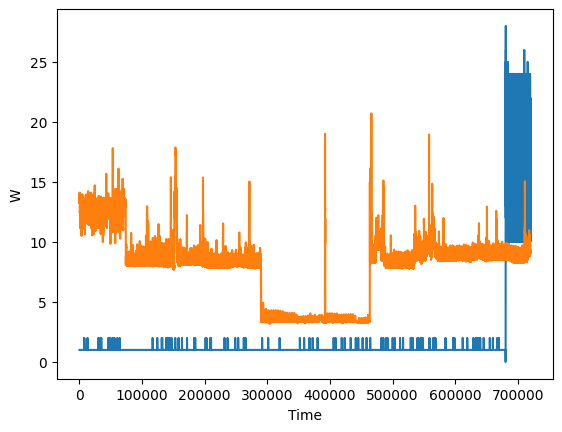

In [10]:
predict = model.predict_generator(test_generator)

plt.plot(y_test)
plt.plot(predict)
plt.xlabel('Time')
plt.ylabel("W")

plt.show()